In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from main.utils import data_manage_utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from main.utils.data_manage_utils import print_time

# Variables
ROOT_PATH = os.path.abspath("../../../")
INPUT_FOLDER = os.path.join(ROOT_PATH, "data/preprocessing/processed_files")

In [2]:
B_X_train, B_y_train, B_X_test, B_y_test = data_manage_utils.load_processed_data_by_folder(os.path.join(INPUT_FOLDER, "B"))
BNEW_X_train, BNEW_y_train, BNEW_X_test, BNEW_y_test = data_manage_utils.load_processed_data_by_folder(os.path.join(INPUT_FOLDER, "B_NEW"))
CCLASS_X_train, CCLASS_y_train, CCLASS_X_test, CCLASS_y_test = data_manage_utils.load_processed_data_by_folder(os.path.join(INPUT_FOLDER, "CCLASS"))

In [3]:
clf = RandomForestClassifier(max_depth=18, random_state=42, class_weight="balanced")
file_sets = ["B", "B_NEW", "CCLASS"]
k = 5


data_sets = [data_manage_utils.load_processed_data_by_folder(os.path.join(INPUT_FOLDER, folder)) for folder in file_sets]

result_dict = {}
for i,data in enumerate(data_sets):
    start, start_str = print_time()
    print(f"Starting run {i+1}/{len(data_sets)} (Name: {file_sets[i]}) at {start_str}:")
    X_train = data[0].to_numpy()
    y_train = data[1].to_numpy().ravel()
    skf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
    
    val_scores = []
    train_scores = []

    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]
        
        # Fit the classifier on the training data
        clf.fit(X_train_fold, y_train_fold)
        
        # Evaluate the classifier on the validation and training data
        v_s = clf.score(X_val_fold, y_val_fold)
        val_scores.append(v_s)
        t_s = clf.score(X_train_fold, y_train_fold)
        train_scores.append(t_s)
    
    # Calculate measures for documentation and plots
    end,end_str = print_time()
    duration = end-start
    mean_val_score = sum(val_scores) / len(val_scores)
    mean_train_score = sum(train_scores) / len(train_scores)
    std_val_score = np.std(val_scores)
    std_train_score = np.std(train_scores)
    
    # Print the mean and standard deviation of the cross-validation scores
    print("\n")
    print("\n=========================")
    print("Validation:")
    print("\tMean accuracy:", mean_val_score)
    print("\tStandard deviation of accuracy:", std_val_score)
    print("Training:")
    print("\tMean accuracy:", mean_train_score)
    print("\tStandard deviation of accuracy:", std_train_score)
    print("Time: ", duration)
    print("=========================\n")
    
    result_dict.update({file_sets[i]:(mean_train_score, mean_val_score)})

result_dict

Starting run 1/3 (Name: B) at 2024_06_12 12:19:



Validation:
	Mean accuracy: 0.7129705611922306
	Standard deviation of accuracy: 0.002524067766417647
Training:
	Mean accuracy: 0.8688251314991844
	Standard deviation of accuracy: 0.001032290647343094
Time:  0:04:01.782082

Starting run 2/3 (Name: B_NEW) at 2024_06_12 12:23:



Validation:
	Mean accuracy: 0.7126639401493942
	Standard deviation of accuracy: 0.0011014137788670523
Training:
	Mean accuracy: 0.8817941582021689
	Standard deviation of accuracy: 0.0009351948194816969
Time:  0:03:38.573955

Starting run 3/3 (Name: CCLASS) at 2024_06_12 12:27:



Validation:
	Mean accuracy: 0.7160795259441873
	Standard deviation of accuracy: 0.002857961746205311
Training:
	Mean accuracy: 0.866034522040698
	Standard deviation of accuracy: 0.000713652140030864
Time:  0:03:27.403340


{'B': (0.8688251314991844, 0.7129705611922306),
 'B_NEW': (0.8817941582021689, 0.7126639401493942),
 'CCLASS': (0.866034522040698, 0.7160795259441873)}

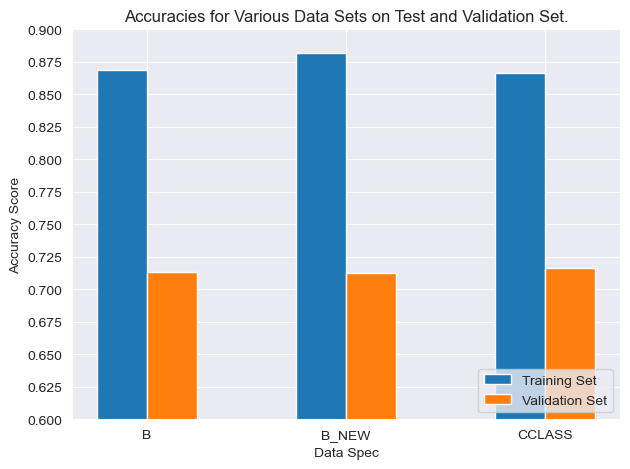

{'B': (0.8688251314991844, 0.7129705611922306),
 'B_NEW': (0.8817941582021689, 0.7126639401493942),
 'CCLASS': (0.866034522040698, 0.7160795259441873)}

In [47]:
idxs = np.arange(3)
label_list = ["Training Set", "Validation Set"]
key_list = list(result_dict.keys())

bar_width = 0.25
y_start = 0.6
y_step = 0.025
y_stop = 0.9

fig, ax = plt.subplots()

value_list = [item[1] for item in result_dict.items()]
for i in range(len(value_list[0])):
    y_vals = [entry[i] for entry in value_list]
    plt.bar(x=idxs - bar_width/2 + bar_width * i, height=y_vals, label = label_list[i], width = bar_width)
    
plt.title("Accuracies for Various Data Sets on Test and Validation Set.") 
ax.set_xlabel("Data Spec")
ax.set_ylabel("Accuracy Score")

plt.xticks(idxs, key_list)
plt.yticks(np.arange(start=y_start,step=y_step, stop=y_stop + y_step))
plt.ylim([y_start,y_stop])

plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
result_dict